### ***'The idea here is to combine an unsupervised learning algorithm and a supervised learning algorithm!'***

### Introduction
The dataset contains the locations of the taxi rank. In this notebook We will define principles clusters of these taxis to build service stations for all taxis operating in this region.

### Libraries we use

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors

import folium
import re

# silhouette_score To select the appropriate number of clusters
from sklearn.metrics import silhouette_score
# kneed will return the knee point of the function.
# The knee point is the point of maximum curvature
from kneed import KneeLocator

### Dataset

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/taxi-data/taxi_data.csv


In [8]:
data = pd.read_csv('../input/taxi-data/taxi_data.csv')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 838 entries, 0 to 837
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LON     837 non-null    float64
 1   LAT     837 non-null    float64
 2   NAME    837 non-null    object 
dtypes: float64(2), object(1)
memory usage: 19.8+ KB


The dataset consists of three variables and contains 837 out of 838 non-zero samples.

In [10]:
# Let's check if there are any duplicates
duplicatedv = data.duplicated(subset = ['LON', 'LAT']).values.sum()
print('{:d} duplicate values'.format(duplicatedv))

14 duplicate values


In [11]:
# Remove duplicates and null values
data.drop_duplicates(
    subset=['LON','LAT'],
    keep='first',
    inplace=True
)
data.dropna(inplace=True)
# Let's check duplicates and null values
duplicatedv_ = data.duplicated(subset = ['LON', 'LAT']).values.sum()
nullv_ = data.isna().values.sum()
print('{:d} valeurs dupliquées'.format(duplicatedv_))
print('{:d} valeurs nulles'.format(nullv_))

0 valeurs dupliquées
0 valeurs nulles


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 823 entries, 0 to 836
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   LON     823 non-null    float64
 1   LAT     823 non-null    float64
 2   NAME    823 non-null    object 
dtypes: float64(2), object(1)
memory usage: 25.7+ KB


The dataset is now clean!

In [13]:
data.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

Clearly this is an unsupervised problem.

### Dataset visualization

display geographic data on the map using **folium** library.

In [14]:
X = data[['LAT', 'LON']].values
map = folium.Map(
    location = [X[:, 0].mean(), X[:, 1].mean()],
    zoom_start = 10
)

In [15]:
for _, row in data.iterrows():
  folium.CircleMarker(
      location = [row.LAT, row.LON],
      radius = 5,
      popup = re.sub(r'\W+', '', row.NAME),
      fill = True,
  ).add_to(map)

In [16]:
map

### KMeans Clustering

First, we will use the simplest clustering method which is the **KMeans** algorithm.

In [17]:
# Choose the best number of clusters using silhouette method
score = -1
scores = []
k = 0
for i in range(2, 101):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
  score_ = silhouette_score(X, kmeans.predict(X))
  scores.append(score_)
  if score_ > score:
    score = score_
    k=i

Best number of clusters is 99 with a score of 0.70


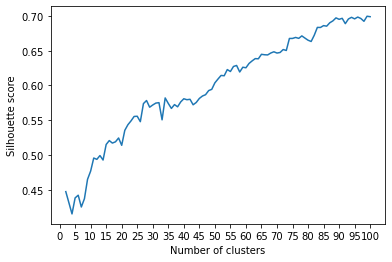

In [18]:
print(
'Best number of clusters is {} with a score of {:.2f}'
.format(k,score)
)
plt.plot(range(2, 101), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xticks(np.arange(0, 101, 5))
plt.show()

silhouette score equal to 0.7 (more than 0.5 and nears 1) is good enough but 99 clusters is a very large number and is not practical.

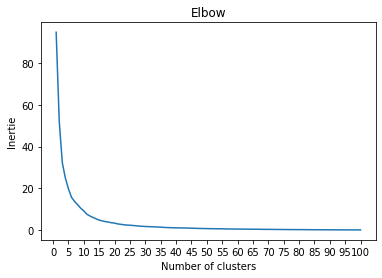

In [19]:
# Choose the best number of clusters using Elbow method
inertia = []
for i in range(1, 101):
  kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
  inertia.append(kmeans.inertia_)
plt.plot(range(1, 101), inertia)
plt.title('Elbow')
plt.xlabel('Number of clusters')
plt.ylabel('Inertie')
plt.xticks(np.arange(0, 101, 5))
plt.show()

In [20]:
knee_point = KneeLocator(
    range(1, 101),
    inertia,
    curve = 'convex',
    direction = 'decreasing'
)
print(knee_point.knee)

11


In [48]:
kmeans = KMeans(n_clusters=11, random_state=0).fit(X)
inertia_ = kmeans.inertia_
silhouette_ = silhouette_score(X, kmeans.labels_)
print("This model with 11 cluster is characterized by :")
# Iinertia is sum of squared distances of samples to their closest cluster center.
print("Iinertia : {:.3f}".format(inertia_))
print("Silhouette mean score : {:.3f}".format(silhouette_))

This model with 11 cluster is characterized by :
Iinertia : 7.649
Silhouette mean score : 0.496


So, accepting this result.

In [22]:
data['Cluster_KMeans'] = kmeans.labels_
data.head()

LON       LAT                          NAME  Cluster_KMeans
0  28.17858 -25.73882         11th Street Taxi Rank              10
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank              10
2  27.83239 -26.53722          Adams Road Taxi Rank               8
3  28.12514 -26.26666  Alberton City Mall Taxi Rank               6
4  28.10144 -26.10567      Alexandra Main Taxi Rank               4

In [23]:
# Show results
colors = ['royalblue', 'maroon', 'forestgreen', 'mediumorchid', 'tan',
          'deeppink', 'olive', 'goldenrod', 'lightcyan', 'navy',
          'springgreen','midnightblue', 'red','brown','limegreen','lime',
          'pink','orchid','crimson','m']*10
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
data['Colors_KMeans'] = vectorizer(kmeans.labels_)
def create_map(cluster_column, colors_column, title):
    map = folium.Map(location=[X[:,0].mean(),X[:,1].mean()],zoom_start=8.5)
    for _,row in data.iterrows():
        folium.CircleMarker(
            location=[row.LAT,row.LON],
            radius=5,
            popup = re.sub(r'\W+', '', row.NAME),
            fill=True,
            color=row[colors_column],
            fill_color=row[colors_column],
        ).add_to(map)

    print(title)
    return map

In [24]:
create_map('Cluster_KMeans','Colors_KMeans','KMeans Clustering')

KMeans Clustering


### DBSCAN

DBSCAN is another clustering algorithm that I find appropriate to use in this problem because we are dealing with geographic data which can have varying cluster shape and density. This algorithm also excludes noise / outliers unlike KMeans which uses all dataset samples. But before we do the DBSCAN calculation, we first need to find the most important parameter, epsilon, which is the maximum distance between points to create a cluster. We can find this using the NearestNeighbors algorithm.

From Scikit-Learn documentation:
*The eps float, default=0.5
The maximum distance between two samples for one to be considered
as in the neighborhood of the other.
The eps is proportional to the expected number of neighbours,
we can use the nearest neighbors to reach a fair estimation for eps.
We still use the kneed library to get the elbow point.*

In [25]:
nearest_neighbors = NearestNeighbors(n_neighbors=7)
neighbors = nearest_neighbors.fit(X)
distances, indices = neighbors.kneighbors(X)
distances = np.sort(distances[:, 5], axis=0)

<Figure size 360x360 with 0 Axes>

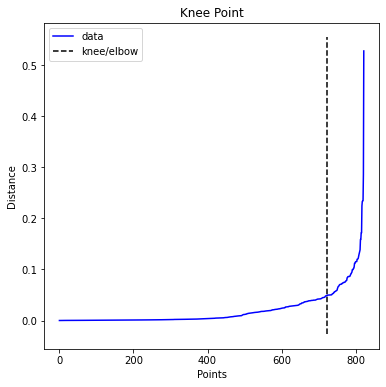

In [26]:
i = np.arange(len(distances))
knee = KneeLocator(
    i, distances, S=1,
    curve='convex',
    direction='increasing',
    interp_method='polynomial'
)
fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
plt.show()

In [27]:
EPS = round(distances[knee.knee],3)
print('The elbow point is at around {}'.format(EPS))

The elbow point is at around 0.05


In [28]:
dbscan = DBSCAN(eps = EPS)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
data['Cluster_DBSCAN'] = dbscan_predictions
vectorizer = np.vectorize(
    lambda x: colors[x % len(colors)]
)
data['Colors_DBSCAN'] = vectorizer(dbscan_predictions)

In [29]:
create_map('Cluster_DBSCAN','Colors_DBSCAN','DBSCAN eps={}'.format(EPS))

DBSCAN eps=0.05


In [30]:
round(silhouette_score(X,dbscan_predictions),2)

0.29

Silhouette equal to 0.29 is not good :(

In [31]:
n_of_clusters = len(np.unique(dbscan_predictions))
n_of_outliers = len(dbscan_predictions[dbscan_predictions==-1])
print('Number of clusters is: {}'.format(n_of_clusters))
print('Number of outliers is: {}'.format(n_of_outliers))
outliers = [
    (counter+2)*x if x == -1 else x
    for counter,x in enumerate(dbscan_predictions)
]

ign_outliers_score = silhouette_score(
    X[dbscan_predictions != -1],
    dbscan_predictions[dbscan_predictions != -1]
)
outliers_singl_score = silhouette_score(X,outliers)
                                                                       
print(
    'Silhouette score without outliers: {:.2f}'
    .format(ign_outliers_score)
    )
print(
    'Silhouette score with outliers: {:.2f}'
    .format(outliers_singl_score)
    )

Number of clusters is: 25
Number of outliers is: 59
Silhouette score without outliers: 0.37
Silhouette score with outliers: 0.12


The score using eps = 0.05 which was calculated using the NearestNeighbors estimate is very low. Let's use another method to determine eps.

In [32]:
scores_no_outlier = []
scores_with_outlier = []
max_score = 0
best_eps = 0
for i in np.arange(0.15, 0, -0.005):
  dbscan = DBSCAN(eps = i)
  dbscan.fit(X)
  dbscan_predictions = dbscan.labels_
  score_without_outlier = silhouette_score(
      X[dbscan_predictions != -1],
      dbscan_predictions[dbscan_predictions != -1]
  )
  scores_no_outlier.append(score_without_outlier)
  outliers = [
              (counter+2)*x if x==-1 else x 
              for counter,x in enumerate(dbscan_predictions)
              ]
  scores_with_outlier.append(silhouette_score(X,outliers))
  if score_without_outlier > max_score:
        max_score = score_without_outlier
        best_eps = i

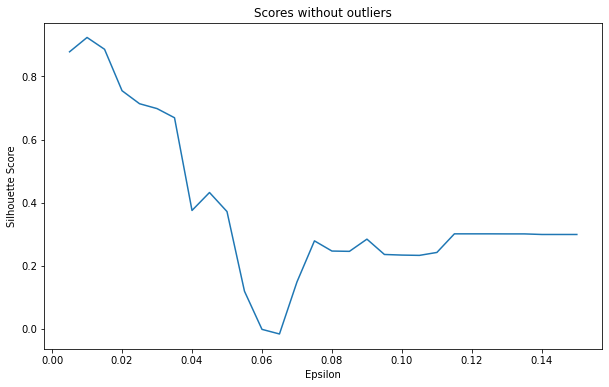

In [33]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0.15,0,-0.005),scores_no_outlier)
plt.xlabel('Epsilon')
plt.ylabel('Silhouette Score')
plt.title('Scores without outliers')
plt.show()

In [34]:
print(
    'Highest score = {} obtained for epsilon = {}'
    .format(round(max_score,3),round(best_eps,3))
)

Highest score = 0.923 obtained for epsilon = 0.01


In [35]:
dbscan = DBSCAN(eps=0.01)
dbscan.fit(X)
dbscan_predictions = dbscan.labels_
data['Cluster_DBSCAN_OPT'] = dbscan_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
data['Colors_DBSCAN_OPT'] = vectorizer(dbscan_predictions)

In [36]:
create_map('Cluster_DBSCAN_OPT','Colors_DBSCAN_OPT','DBSCAN OPT')

DBSCAN OPT


In [37]:
print('Number of clusters: {}'
  .format(len(np.unique(dbscan_predictions))))
print('Number of outliers: {}'
  .format(len(dbscan_predictions[dbscan_predictions==-1])))
outliers=[
          (counter+2)*x if x==-1 else x 
          for counter,x in enumerate(dbscan_predictions)]
print('Silhouette score without outliers: {}'
  .format(
      silhouette_score(X[dbscan_predictions!=-1],
      dbscan_predictions[dbscan_predictions!=-1])))
print('Silhouette score with outliers: {}'
  .format(silhouette_score(X,outliers)))

Number of clusters: 51
Number of outliers: 289
Silhouette score without outliers: 0.9232138256614868
Silhouette score with outliers: 0.5667489355530314


We get highest score by estimating the eps value using the Silhouette. Outliers values are identified as non-clustered values.

### Semi-supervised Learning

We can deal with outliers using a hybrid algorithm, DBSCAN + KNearestNeighbors. The idea here is to combine an unsupervised learning algorithm and a supervised learning algorithm. Since we already have cluster groups obtained from DBSCAN, we will rank the outliers using KNN.

In [38]:
X_train = data[data['Cluster_DBSCAN_OPT'] != -1][['LON', 'LAT']]
y_train = data[data['Cluster_DBSCAN_OPT'] != -1][['Cluster_DBSCAN_OPT']]
X_pred = data[data['Cluster_DBSCAN_OPT'] == -1][['LON', 'LAT']]

In [39]:
print('Dimensions matrix: X_train ')
print(X_train.head())

Dimensions matrix: X_train 
        LON       LAT
0  28.17858 -25.73882
1  28.17660 -25.73795
4  28.10144 -26.10567
5  28.10125 -26.10605
6  28.10185 -26.10537


In [40]:
print('Labels vector: y_train')
print(y_train.head())

Labels vector: y_train
   Cluster_DBSCAN_OPT
0                   0
1                   0
4                   1
5                   1
6                   1


In [41]:
print('Samples to be classified: X_pred')
print(X_pred.head())

Samples to be classified: X_pred
         LON       LAT
2   27.83239 -26.53722
3   28.12514 -26.26666
10  28.51206 -26.43641
15  28.28036 -26.15972
24  27.70334 -26.28271


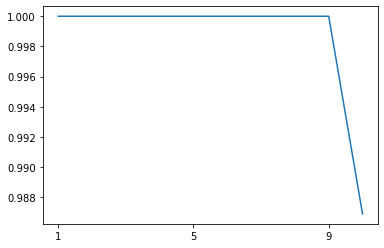

In [42]:
# Before we use the model, let us first check
# the best number of neighbors to use
scores = []
for i in range(1, 11):
  knc = KNeighborsClassifier(n_neighbors=i)
  knc.fit(X_train, y_train.values.ravel())
  scores.append(knc.score(X_train, y_train))
plt.plot(range(1, 11), scores)
plt.xticks(np.arange(1, 11, 4))
plt.show()

ok, let's take n_neighbors = 5

In [43]:
KNC = KNeighborsClassifier(n_neighbors=5)
KNC.fit(X_train, y_train.values.ravel())
KNC_predictions = KNC.predict(X_pred)

In [44]:
data['Cluster_Hybrid'] = data['Cluster_DBSCAN_OPT']
data.loc[data['Cluster_DBSCAN_OPT'] == -1, 'Cluster_Hybrid'] = KNC_predictions
vectorizer = np.vectorize(lambda x: colors[x % len(colors)])
data['Colors_Hybrid'] = vectorizer(data['Cluster_Hybrid'].values)

In [45]:
create_map('Cluster_Hybrid','Colors_Hybrid','Hybrid (DBSCAN + KNN)')

Hybrid (DBSCAN + KNN)


In [46]:
print(
    'Number of clusters: {}'
    .format(len(np.unique(data['Cluster_Hybrid']))))
print(
    'Silhouette score: {}'
    .format(round(silhouette_score(X,data['Cluster_Hybrid']),2)))

Number of clusters: 50
Silhouette score: 0.51


### Conclusion

In this problem, we used different clustering techniques. We started with the KMeans algorithm, which is the simplest and fastest clustering algorithm. We have shown that DBSCAN works well on geolocation data, but selecting the epsilon value is critical. We must also remember that the Silhouette score near -1 is the worst and 1 is the best. But Silhouette can only be used as a guide for tuning hyperparameters and not as an absolute metric for whether the cluster is good or not. There is another algorithm better than DBSCAN like **HDBSCAN** which is based on **hierarchical clustering** and is efficient for variable density data which is applicable here because taxi density is higher around town and less far from town .